# Assignment 2: sentiment analysis of SUTD Reddit
**Assignment due 21 March 11:59pm**

Welcome to the second assignment for 50.055 Machine Learning Operations. These assignments give you a chance to practice the methods and tools you have learned. 

**This assignment is an individual assignment.**

- Read the instructions in this notebook carefully
- Add your solution code and answers in the appropriate places. The questions are marked as **QUESTION:**, the places where you need to add your code and text answers are marked as **ADD YOUR SOLUTION HERE**
- The completed notebook, including your added code and generated output and a labeled dataset which you create in the assignment will be your submission for the assignment.
- The notebook should execute without errors from start to finish when you select "Restart Kernel and Run All Cells..". Please test this before submission.
- Use the SUTD Education Cluster to solve and test the assignment.

**Rubric for assessment** 

Your submission will be graded using the following criteria. 
1. Code executes: your code should execute without errors. The SUTD Education cluster should be used to ensure the same execution environment.
2. Correctness: the code should produce the correct result or the text answer should state the factual correct answer.
3. Style: your code should be written in a way that is clean and efficient. Your text answers should be relevant, concise and easy to understand.
4. Partial marks will be awarded for partially correct solutions.
5. There is a maximum of 150 points for this assignment.

**ChatGPT policy** 

If you use AI tools, such as ChatGPT, to solve the assignment questions, you need to be transparent about its use and mark AI-generated content as such. In particular, you should include the following in addition to your final answer:
- A copy or screenshot of the prompt you used
- The name of the AI model
- The AI generated output
- An explanation why the answer is correct or what you had to change to arrive at the correct answer

**Assignment Notes:** Please make sure to save the notebook as you go along. Submission Instructions are located at the bottom of the notebook.


In [3]:
# # Installing all required packages
# # Note: Do not add to this list.
# # ----------------
# ! pip install transformers[torch]==4.37.2
# ! pip install datasets==2.17.1
# ! pip install seaborn==0.13.2
# ! pip install pyarrow==15.0.0
# ! pip install scikit-learn==1.4.0
# ! pip install emoji==0.6.0
# ! pip install accelerate==0.27.2
# # ----------------

In [4]:
# Importing all required packages
# ----------------
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AutoTokenizer
from transformers import pipeline
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification
from datasets import Dataset
# ----------------

In [5]:
%matplotlib inline


# Sentiment analysis

Sentiment analysis is a natural language processing technique that identifies the polarity of a given text. There are different flavors of sentiment analysis, but one of the most widely used techniques labels data into positive, negative and neutral. We have already encountererd sentiment analysis in the hands-on sessions.

In this assignment, you will conduct sentiment analysis on posts and comments from the SUTD subreddit. You will run experiments with pre-trained sentiment models, evaluate their performance and simulate improving the model by re-training it with newly annotated data. 


In [6]:
# Load SUTD subreddit data set as dataframe
# posts and comments have been downloaded from https://www.reddit.com/r/sutd/

df_submissions = pd.read_parquet('reddit_submissions.parquet.gzip').set_index("Id")
df_comments = pd.read_parquet('reddit_comments.parquet.gzip').set_index("CommentId")

In [7]:
#Let's have a look at the data. The data schema is as follows.

# Submissions
# Id - unique id for submission
# Title - text of the submission title
# Upvotes - upvotes on this submission
# Created - date time of submission creation date and time

# Comments
# CommentId - unique id for comment
# Comment - text content of the comment
# CommentCreated - date time of comment creation date and time
# Id - unique id for submission on which the comment was posted

# See the Reddit API documentation for details https://www.reddit.com/dev/api/
df_submissions

,Title,Upvotes,Created
Id,,,
xtdia0,"Oh boy, 8am lectures. My favorite",627,2022-10-02 02:49:01
scyaig,IF I get my engineering degree,413,2022-01-26 05:24:35
zzxqop,Happy New Year!,339,2022-12-31 16:26:57
rbe5cz,Happy finals!,319,2021-12-08 00:45:22
zlci46,You know who you are,266,2022-12-14 00:46:23
...,...,...,...
b7nv4i,SUTD started sending rejection letter already?,3,2019-03-31 13:41:25
b579t4,upcoming SUTD interviews,3,2019-03-25 06:47:32
b41vpw,Another new (prospective) undergraduate!,3,2019-03-22 07:04:34


In [8]:
df_comments

,Comment,CommentCreated,Id
CommentId,,,
iqps23l,HAHA Issa mood boiii,2022-10-02 05:25:29,xtdia0
iqrmg9d,Me everyday on a school day,2022-10-02 16:26:59,xtdia0
iqso6tt,Nothing a Vid test can't fix,2022-10-02 20:19:01,xtdia0
iqpmt6t,I thought the earliest lecture we can get is 8...,2022-10-02 04:26:53,xtdia0
j2gyvln,jan 3rd is when my secondary school starts,2023-01-01 05:13:21,zzxqop
...,...,...,...
jkrjznb,hey! got my acceptance today,2023-05-19 12:45:12,13jqat4
johzqeu,"hi y’allz, mine updated to unsuccessful, wishi...",2023-06-17 18:50:10,13jqat4
jo1hrsu,I’m an international student from china and I ...,2023-06-13 22:37:17,13jqat4


You can read the SUTD reddit submissions in your web browser by navigating to 
https://www.reddit.com/r/sutd/comments/{Id}


### QUESTION: 
How easy is it to make sense of the submissions and comments? Is it easier to understand the posts when you read them in the browser? 
Explain why or why not (max 100 words)

**--- ADD YOUR SOLUTION HERE (5 points)---**


------------------------------


Its more difficult to make sense of the submissions and comments by reading it as a dataframe as all the formatting is missing, also all the previous context is missing. Reading from the browser is definetly better as we can see the full discussion thread

In [9]:
# QUESTION: Join the data frames into a joined data_frame 'df_reddit' which  contains both submissions and comments. 
# Each row should contain a submission paired with one associated comment. Comments that do not have a matching submission shall be dropped. The joined data frame should have the following schema.

# Submissions
# Id - unique id for submission
# Title - text of the submission title
# Upvotes - upvotes on this submission
# Created - date time of submission creation date and time
# CommentId - unique id for comment, comment is posted for this submission
# Comment - text content of the comment
# CommentCreated - date time of comment creation date and time


#--- ADD YOUR SOLUTION HERE (5 points)---
# Join submissions and comments into a single data frame
df_reddit = pd.merge(
    df_comments.reset_index(),
    df_submissions.reset_index(),
    on="Id",
    how="inner"
)[['Id', 'Title', 'Upvotes', 'Created', 'CommentId', 'Comment', 'CommentCreated']]

#------------------------------

In [10]:
# Print the first 10 rows of the joined data frame
df_reddit.head(10)

# Hint: submission will be duplicated as many times as there are comments

,Id,Title,Upvotes,Created,CommentId,Comment,CommentCreated
0,xtdia0,"Oh boy, 8am lectures. My favorite",627,2022-10-02 02:49:01,iqps23l,HAHA Issa mood boiii,2022-10-02 05:25:29
1,xtdia0,"Oh boy, 8am lectures. My favorite",627,2022-10-02 02:49:01,iqrmg9d,Me everyday on a school day,2022-10-02 16:26:59
2,xtdia0,"Oh boy, 8am lectures. My favorite",627,2022-10-02 02:49:01,iqso6tt,Nothing a Vid test can't fix,2022-10-02 20:19:01
3,xtdia0,"Oh boy, 8am lectures. My favorite",627,2022-10-02 02:49:01,iqpmt6t,I thought the earliest lecture we can get is 8...,2022-10-02 04:26:53
4,zzxqop,Happy New Year!,339,2022-12-31 16:26:57,j2gyvln,jan 3rd is when my secondary school starts,2023-01-01 05:13:21
5,zzxqop,Happy New Year!,339,2022-12-31 16:26:57,j54ub3e,"HEY, FUCK YOU",2023-01-20 12:15:41
6,zzxqop,Happy New Year!,339,2022-12-31 16:26:57,j2hjzse,"Meanwhile me who has work on christmas eve, ch...",2023-01-01 09:44:48
7,zzxqop,Happy New Year!,339,2022-12-31 16:26:57,j2i7d80,hahahaaha same,2023-01-01 14:48:55
8,zzxqop,Happy New Year!,339,2022-12-31 16:26:57,j2m5mdr,f school man,2023-01-02 09:54:47
9,zzxqop,Happy New Year!,339,2022-12-31 16:26:57,j4fvc93,Same,2023-01-15 12:41:33


In [11]:
# Now let's run a pre-trained sentiment analysis model on the submissions and comments
# A convenient way to execute pre-trained models for standard tasks are Huggingface pipelines
# Here we run a standard sentiment analysis pipeline on the first ten submission titles 
sentiment_pipeline = pipeline("sentiment-analysis", device=0)
print(sentiment_pipeline(list(df_submissions['Title'][:10])))

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
c:\Users\Parthasarathy.Harini\Downloads\NLP\.venv\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[{'label': 'POSITIVE', 'score': 0.9927398562431335}, {'label': 'NEGATIVE', 'score': 0.7195634841918945}, {'label': 'POSITIVE', 'score': 0.999868631362915}, {'label': 'POSITIVE', 'score': 0.9998632669448853}, {'label': 'POSITIVE', 'score': 0.9992561936378479}, {'label': 'POSITIVE', 'score': 0.5723458528518677}, {'label': 'NEGATIVE', 'score': 0.9995667338371277}, {'label': 'POSITIVE', 'score': 0.9972499012947083}, {'label': 'NEGATIVE', 'score': 0.9956018924713135}, {'label': 'NEGATIVE', 'score': 0.9826338887214661}]


In [12]:
# QUESTION: Complete the function 'analyse_sentiment' which takes a data frame, a Huggingface sentiment pipeline object 
# and a target column name and adds two columns 'Label' and 'Score' to the data frame in place.
# pass the provided tokenizer arguments to the pipeline
# The new columns should contain the sentiment labels and scores, respectively.


def analyse_sentiment(df, sentiment_pipeline, column):
    tokenizer_kwargs = {'padding':True, 'truncation':True, 'max_length':128,}
#--- ADD YOUR SOLUTION HERE (10 points)---

    
    texts = list(df[column])
    results = sentiment_pipeline(texts, **tokenizer_kwargs)
    labels = [result['label'] for result in results]
    scores = [result['score'] for result in results]
    df['Label'] = labels
    df['Score'] = scores
#------------------------------

In [13]:
# add sentiment labels and scores to the submissions and comments dataframes
analyse_sentiment(df_submissions, sentiment_pipeline, 'Title')
analyse_sentiment(df_comments, sentiment_pipeline, 'Comment')


In [14]:
# display dataframe 
df_submissions

,Title,Upvotes,Created,Label,Score
Id,,,,,
xtdia0,"Oh boy, 8am lectures. My favorite",627,2022-10-02 02:49:01,POSITIVE,0.992740
scyaig,IF I get my engineering degree,413,2022-01-26 05:24:35,NEGATIVE,0.719563
zzxqop,Happy New Year!,339,2022-12-31 16:26:57,POSITIVE,0.999869
rbe5cz,Happy finals!,319,2021-12-08 00:45:22,POSITIVE,0.999863
zlci46,You know who you are,266,2022-12-14 00:46:23,POSITIVE,0.999256
...,...,...,...,...,...
b7nv4i,SUTD started sending rejection letter already?,3,2019-03-31 13:41:25,NEGATIVE,0.998578
b579t4,upcoming SUTD interviews,3,2019-03-25 06:47:32,POSITIVE,0.845063
b41vpw,Another new (prospective) undergraduate!,3,2019-03-22 07:04:34,POSITIVE,0.967637


In [15]:
# display dataframe 
df_comments

,Comment,CommentCreated,Id,Label,Score
CommentId,,,,,
iqps23l,HAHA Issa mood boiii,2022-10-02 05:25:29,xtdia0,NEGATIVE,0.881345
iqrmg9d,Me everyday on a school day,2022-10-02 16:26:59,xtdia0,POSITIVE,0.987902
iqso6tt,Nothing a Vid test can't fix,2022-10-02 20:19:01,xtdia0,NEGATIVE,0.999672
iqpmt6t,I thought the earliest lecture we can get is 8...,2022-10-02 04:26:53,xtdia0,NEGATIVE,0.992340
j2gyvln,jan 3rd is when my secondary school starts,2023-01-01 05:13:21,zzxqop,NEGATIVE,0.696360
...,...,...,...,...,...
jkrjznb,hey! got my acceptance today,2023-05-19 12:45:12,13jqat4,POSITIVE,0.999398
johzqeu,"hi y’allz, mine updated to unsuccessful, wishi...",2023-06-17 18:50:10,13jqat4,POSITIVE,0.619022
jo1hrsu,I’m an international student from china and I ...,2023-06-13 22:37:17,13jqat4,POSITIVE,0.651069


### QUESTION: 
From a first inspection of the results, what problems can you see with our current sentiment analysis?
What model is used for the sentiment analysis and how was is trained?

**--- ADD YOUR SOLUTION HERE (5 points) ---**
the current sentiment analysis is not good at classifying sarcastic statements, it doesnt account for neutral cases as well. There is also no consideration for context specific sentiment patterns.
The default model is distilbert-base-uncased-finetuned-sst-2-english
------------------------------


In [16]:
# QUESTION: Update the sentiment pipeline to use the model "finiteautomata/bertweet-base-sentiment-analysis" from Huggingface
# The model should output three classes: 'POS', 'NEG', 'NEU'
# Store the model name in separate variable "model_name"

#--- ADD YOUR SOLUTION HERE (5 points) ---
#------------------------------
model_name = "finiteautomata/bertweet-base-sentiment-analysis"
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name, device=0)

c:\Users\Parthasarathy.Harini\Downloads\NLP\.venv\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### QUESTION: 

Explain why this model is better suited for the task (max 100 words).

**--- ADD YOUR SOLUTION HERE (5 points) ---**


Bertweet is better as its trained on twitter data which has a similar language context to reddit, ie. its more casual. this model also addresses the issue brought up previously of not having neutral classification. 
------------------------------


In [17]:
# re-run the sentiment analysis of submissions and comments
analyse_sentiment(df_submissions, sentiment_pipeline, 'Title')
analyse_sentiment(df_comments, sentiment_pipeline, 'Comment')


In [18]:
# display dataframe 
df_submissions

,Title,Upvotes,Created,Label,Score
Id,,,,,
xtdia0,"Oh boy, 8am lectures. My favorite",627,2022-10-02 02:49:01,POS,0.987462
scyaig,IF I get my engineering degree,413,2022-01-26 05:24:35,NEU,0.846714
zzxqop,Happy New Year!,339,2022-12-31 16:26:57,POS,0.992498
rbe5cz,Happy finals!,319,2021-12-08 00:45:22,POS,0.992441
zlci46,You know who you are,266,2022-12-14 00:46:23,NEU,0.611753
...,...,...,...,...,...
b7nv4i,SUTD started sending rejection letter already?,3,2019-03-31 13:41:25,NEG,0.825060
b579t4,upcoming SUTD interviews,3,2019-03-25 06:47:32,NEU,0.963418
b41vpw,Another new (prospective) undergraduate!,3,2019-03-22 07:04:34,POS,0.675289


In [19]:
# display dataframe 
df_comments

,Comment,CommentCreated,Id,Label,Score
CommentId,,,,,
iqps23l,HAHA Issa mood boiii,2022-10-02 05:25:29,xtdia0,POS,0.764860
iqrmg9d,Me everyday on a school day,2022-10-02 16:26:59,xtdia0,NEU,0.932430
iqso6tt,Nothing a Vid test can't fix,2022-10-02 20:19:01,xtdia0,POS,0.808931
iqpmt6t,I thought the earliest lecture we can get is 8...,2022-10-02 04:26:53,xtdia0,NEU,0.962069
j2gyvln,jan 3rd is when my secondary school starts,2023-01-01 05:13:21,zzxqop,NEU,0.972655
...,...,...,...,...,...
jkrjznb,hey! got my acceptance today,2023-05-19 12:45:12,13jqat4,POS,0.968053
johzqeu,"hi y’allz, mine updated to unsuccessful, wishi...",2023-06-17 18:50:10,13jqat4,NEG,0.874081
jo1hrsu,I’m an international student from china and I ...,2023-06-13 22:37:17,13jqat4,NEG,0.901180


In [20]:
# QUESTION: What is the time frame covered by the data set, i.e. what is the earliest time of a submission or comment and what is the most recent time?
# Find the earliest and latest timestamp and print them
#--- ADD YOUR SOLUTION HERE (8 points)---
earliest_submission = df_submissions['Created'].min()
latest_submission = df_submissions['Created'].max()
earliest_comment = df_comments['CommentCreated'].min()
latest_comment = df_comments['CommentCreated'].max()

earliest_overall = min(earliest_submission, earliest_comment)
latest_overall = max(latest_submission, latest_comment)

print(f"Earliest timestamp: {earliest_overall}")
print(f"Latest timestamp: {latest_overall}")
#------------------------------

Earliest timestamp: 2017-11-12 17:06:27
Latest timestamp: 2024-01-24 03:39:32


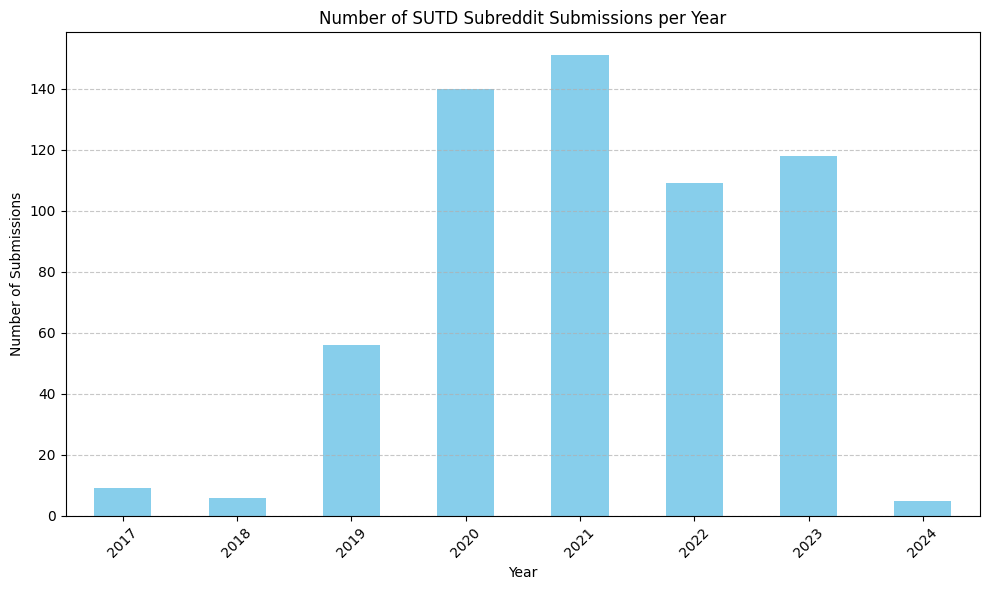

In [21]:
# QUESTION: How did the volume of posts on the SUTD subreddit change over the years?
# Create a bar chart diagram that plots the number of submissions per year on the y-axis and the year on the x-axis.

#--- ADD YOUR SOLUTION HERE (8 points) ---
df_submissions['Year'] = pd.DatetimeIndex(df_submissions['Created']).year
submissions_per_year = df_submissions.groupby('Year').size()
plt.figure(figsize=(10, 6))
submissions_per_year.plot(kind='bar', color='skyblue')
plt.title('Number of SUTD Subreddit Submissions per Year')
plt.xlabel('Year')
plt.ylabel('Number of Submissions')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
#------------------------------

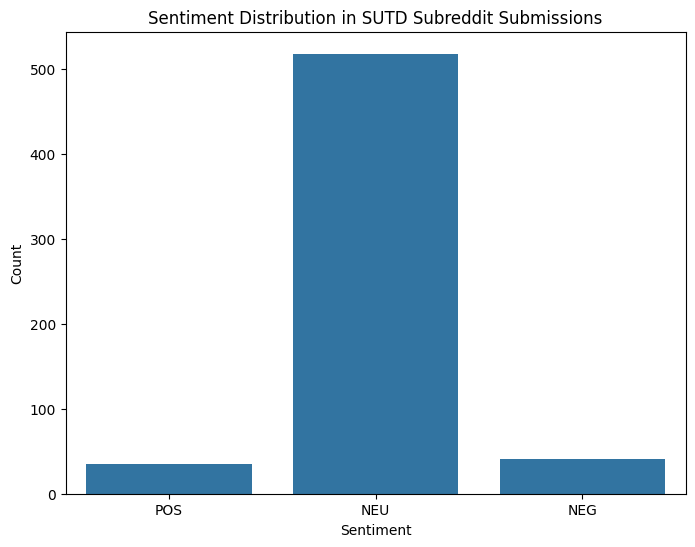

In [22]:
# QUESTION: What is the distribution of positive, neutral and negative sentiment?
# Create a bar chart diagram that plots the number of submissions on the y-axis and the sentiment label on the x-axis.

#--- ADD YOUR SOLUTION HERE (5 points)---
# Distribution of sentiment in submissions
plt.figure(figsize=(8, 6))
sns.countplot(x='Label', data=df_submissions)
plt.title('Sentiment Distribution in SUTD Subreddit Submissions')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


#------------------------------

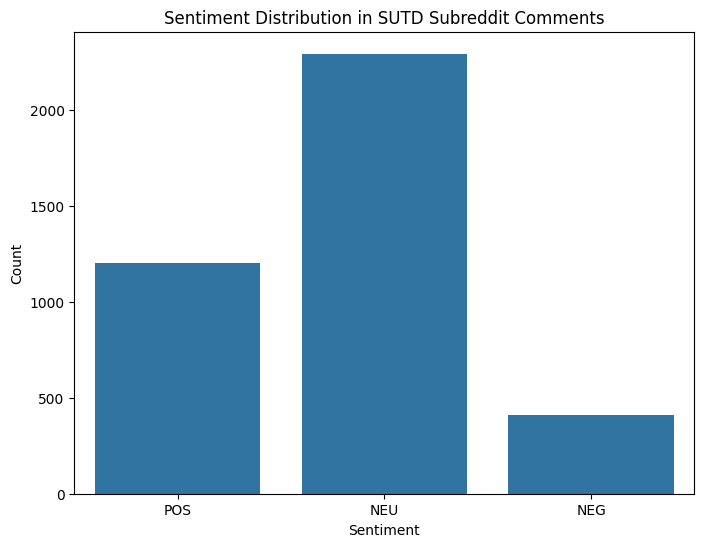

In [23]:
# QUESTION: What is the distribution of positive, neutral and negative sentiment for comments?
# Create a bar chart diagram that plots the number of comments on the y-axis and the sentiment label on the x-axis.

#--- ADD YOUR SOLUTION HERE (5 points)---
plt.figure(figsize=(8, 6))
sns.countplot(x='Label', data=df_comments)
plt.title('Sentiment Distribution in SUTD Subreddit Comments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()
#------------------------------

In [24]:
# QUESTION: combine submission titles and comments for the time period from 2021 until today into one data frame.
# The resulting data frame 'df_text' should have the following schema

# Id - unique id of the comment or the submissions, this column is the index of the data frame 
# Text - text content of the comment or the submission title
# Created - date time when submission or comment was created
# Label - sentiment label as predicted by ML

#--- ADD YOUR SOLUTION HERE (10 points)---
df_submissions['Created'] = pd.to_datetime(df_submissions['Created'])
df_comments['CommentCreated'] = pd.to_datetime(df_comments['CommentCreated'])
submissions_2021 = df_submissions[df_submissions['Created'] >= '2021-01-01'].copy()
submissions_2021 = submissions_2021[['Title', 'Created', 'Label']]
submissions_2021.rename(columns={'Title': 'Text'}, inplace=True)
submissions_2021 = submissions_2021.reset_index()
comments_2021 = df_comments[df_comments['CommentCreated'] >= '2021-01-01'].copy()
comments_2021 = comments_2021[['Comment', 'CommentCreated', 'Label']]
comments_2021.rename(columns={'Comment': 'Text', 'CommentCreated': 'Created'}, inplace=True)
comments_2021 = comments_2021.reset_index()
comments_2021.rename(columns={'CommentId': 'Id'}, inplace=True)
df_text = pd.concat([submissions_2021, comments_2021], ignore_index=False)
df_text.set_index('Id', inplace=True)
#------------------------------

In [25]:
# inspect the resulting data frame
df_text

,Text,Created,Label
Id,,,
xtdia0,"Oh boy, 8am lectures. My favorite",2022-10-02 02:49:01,POS
scyaig,IF I get my engineering degree,2022-01-26 05:24:35,NEU
zzxqop,Happy New Year!,2022-12-31 16:26:57,POS
rbe5cz,Happy finals!,2021-12-08 00:45:22,POS
zlci46,You know who you are,2022-12-14 00:46:23,NEU
...,...,...,...
jkrjznb,hey! got my acceptance today,2023-05-19 12:45:12,POS
johzqeu,"hi y’allz, mine updated to unsuccessful, wishi...",2023-06-17 18:50:10,NEG
jo1hrsu,I’m an international student from china and I ...,2023-06-13 22:37:17,NEG


In [26]:
# QUESTION: sort the data frame by date time descending and save it in the same variable

#--- ADD YOUR SOLUTION HERE (3 points)---
df_text = df_text.sort_values('Created', ascending=False)
#------------------------------

In [27]:
# inspect the resulting data frame
df_text

,Text,Created,Label
Id,,,
kjaudx2,Unfortunately no and I don’t foresee it to cha...,2024-01-24 03:39:32,NEG
kjau765,Hi! I would like to ask if it is possible for ...,2024-01-24 03:38:13,NEU
kj74anz,"Thks! Hope you have a great FEAST II, all the ...",2024-01-23 14:25:22,POS
kj6z72l,"I see, wishing you all the best for the result...",2024-01-23 13:50:05,POS
kj6x184,"Haha yup, should be out by tmr. Yes, FEAST II ...",2024-01-23 13:34:29,POS
...,...,...,...
ghwf0at,Yes. I am indoneisan myself. In fact we have a...,2021-01-03 04:32:08,NEU
kpde9d,Subjects in Year 1,2021-01-03 04:13:53,NEU
kp0zuf,HASS mod recommendation,2021-01-02 17:02:09,NEU


In [28]:
# save data frame to csv
df_text.to_csv("reddit.csv")


Download the csv file and open it in a spreadsheet application or text editor. 

Inspec the first 10-20 entries in the list to get a feeling for the data domain.

### QUESTION: 
Write a short labeling guide for annotating the SUTD reddit data with sentiment labels. 
You can write the labeling guide in a bullet point format and should have 5-10 points.

**--- ADD YOUR SOLUTION HERE (10 points)---**
Positive(POS):
-Happy content, satisfaction, excitement
-Posts that are helpful
-Posts that are supportive/encoraging

Neutral(NEU):
- Observations about courses
- Objective sharing of info 
- general inquiries about sutd
- announcements
- content that has both positive and negative elements

Negative(NEG):
-COmplaints about courses
-Angry content, frustrated or dissapointed
- Criticism 
- posts about difficulties


------------------------------


## Label the data
Add a new column 'HumanLabel' to the csv file and label the 500 most recent entries, including the first 10-20 you inspected to create the label guide, using a spreadsheet application (Excel, Google Docs, Numbers) or just a text editor. 

### QUESTION: 
What were some of the ambiguous cases or corner cases you encountered?
List 3-5 issues

**--- ADD YOUR SOLUTION HERE (30 points)---**


One word responses such as "Yes" "No" or "maybe"

Lack of any context in some comments

Contrasting emojis vs content
------------------------------


Upload your 500 labeled instances as **reddit_labeled.csv** to JupyterLab.

## Evaluate
Compare your human-corrected labels with the original predicted labels.

In [29]:
# 
# QUESTION: Read the 500 labeled rows from the CSV file into a dataframe "df_labeled". 
# The data frame should have this schema.

# Id - unique id of the comment or the submissions, Id is the index of the data frame 
# Text - text content of the comment or the submission title
# Created - date time when submission or comment was created
# Label - sentiment label as predicted by ML
# HumanLabel - manually reviewed 'gold sentiment label'

#--- ADD YOUR SOLUTION HERE (5 points)---

df_labeled = pd.read_csv('reddit_labeled.csv')
#------------------------------


In [30]:
# check the data was loaded correctly
df_labeled

,Unnamed: 0,Id,Text,Created,Label,HumanLabel
0,178,jzswku1,I have done an Aptitude test but I am aware th...,9/9/2023 11:39,NEU,NEU
1,179,jzso3ue,"Good day sir, Im taking my Feast test 2 this c...",9/9/2023 10:01,NEU,NEU
2,2023,hc5syyt,"Hi, you should have received some emails from ...",9/9/2021 8:53,NEU,NEU
3,2024,pkre3k,Fifth Rows,9/9/2021 5:19,NEU,NEU
4,222,jveme8g,ur sutd email is just ur first name_lastname@m...,9/8/2023 5:33,NEU,NEU
...,...,...,...,...,...,...
495,1689,i3hryvp,Day after day\n\nAs time flies away\n\nI think...,5/4/2022 14:23,NEG,NEU
496,1690,twvwmf,)))),5/4/2022 14:13,POS,NEU
497,2586,gtfdzux,"Slack is a religion, not a mindset.",5/4/2021 6:18,NEU,NEU
498,2587,gtfdz2l,Truer words have not been spoken.,5/4/2021 6:18,POS,NEU


In [31]:
# split the labeled data into two chunks, ordered by time
df_labeled.sort_values('Created', ascending=True, inplace=True)

df_labeled1 = df_labeled[:250]
df_labeled2 = df_labeled[250:]

In [32]:
# check that the each split is 250 instances and that they don't overlap
df_labeled1


,Unnamed: 0,Id,Text,Created,Label,HumanLabel
499,2588,gtf8d3k,"All soft copy. However, feel free to jot down ...",5/4/2021 5:01,NEU,NEU
498,2587,gtfdz2l,Truer words have not been spoken.,5/4/2021 6:18,POS,NEU
497,2586,gtfdzux,"Slack is a religion, not a mindset.",5/4/2021 6:18,NEU,NEU
496,1690,twvwmf,)))),5/4/2022 14:13,POS,NEU
495,1689,i3hryvp,Day after day\n\nAs time flies away\n\nI think...,5/4/2022 14:23,NEG,NEU
...,...,...,...,...,...,...
254,676,jj6n3s7,"Hey, did u manage to appeal? I'm in the same s...",7/5/2023 7:03,NEU,NEU
253,2218,h0wqtck,[removed],7/6/2021 13:57,NEU,NEU
252,2217,h0wqvzy,Not as nevertheless as joe mum\n***\n^I ^am ^a...,7/6/2021 13:58,NEG,NEU
251,423,jnavr56,did you received admission appeal on interview...,7/6/2023 20:15,NEU,NEU


In [33]:
df_labeled2


,Unnamed: 0,Id,Text,Created,Label,HumanLabel
249,2173,ofg1qu,Graduate research experience at SUTD,7/7/2021 10:16,NEU,NEU
248,2172,h4d749t,Make sense! Did u email the school to check fo...,7/7/2021 15:57,NEU,NEU
247,300,jqz344t,"no need to pay anything, i got accepted awhile...",7/7/2023 2:28,NEU,NEU
246,37,kgwv7g6,"I dont know anyone, but for ASEAN, T&Cs state ...",8/1/2024 16:23,NEU,NEU
245,40,kgufvu6,what if you never took A math?,8/1/2024 4:13,NEU,NEU
...,...,...,...,...,...,...
4,222,jveme8g,ur sutd email is just ur first name_lastname@m...,9/8/2023 5:33,NEU,NEU
3,2024,pkre3k,Fifth Rows,9/9/2021 5:19,NEU,NEU
2,2023,hc5syyt,"Hi, you should have received some emails from ...",9/9/2021 8:53,NEU,NEU
1,179,jzso3ue,"Good day sir, Im taking my Feast test 2 this c...",9/9/2023 10:01,NEU,NEU


In [34]:
# Compute the agreement between the predicted labels and your manually created "gold labels" in split 1. 
# Compute scores for overall accuracy as well as precision/recall/f1 score for each label class
# Print all scores 

print(sklearn.metrics.classification_report(df_labeled1["Label"], df_labeled1["HumanLabel"]))

              precision    recall  f1-score   support

         NEG       0.33      0.04      0.06        28
         NEU       0.66      0.99      0.79       150
         POS       1.00      0.29      0.45        72

    accuracy                           0.68       250
   macro avg       0.66      0.44      0.44       250
weighted avg       0.72      0.68      0.61       250



In [35]:
# Compute the agreement between the predicted labels and your manually created "gold labels" in split 2. 
# Compute scores for overall accuracy as well as precision/recall/f1 score for each label class
# Print all scores 

print(sklearn.metrics.classification_report(df_labeled2["Label"], df_labeled2["HumanLabel"]))

              precision    recall  f1-score   support

         NEG       0.33      0.09      0.14        22
         NEU       0.72      0.96      0.82       164
         POS       0.88      0.36      0.51        64

    accuracy                           0.73       250
   macro avg       0.65      0.47      0.49       250
weighted avg       0.73      0.73      0.68       250



## Retrain sentiment model

Now let us use the data in df_labeled1 to try improve the sentiment classifier.
Train the Huggingface model you have chosen with the 250 examples and your human gold labels.

Start by converting the data from data frames into a 2 Huggingface datasets. 
- dataset1 : a Huggingface dataset object which includes the data from dataframe df_labeled1
- dataset2 : a Huggingface dataset object which includes the data from dataframe df_labeled2


In each dataset, there should be the following fields
- text : the text of the reddit submission or comment
- label: the human gold label, encoded as integer

With these dataset we will simulate the process of improving a model in production. Dataset1 is simulating a batch of data which we observed in production, annotated and then use to improve the model. We evaluate the change on the new training data and on the next batch of production data, simulated by dataset2.


In [ ]:
def convert_label(df, pipeline):
    df = df.drop("Label", axis=1)
    label_id_mapping = lambda label: pipeline.model.config.label2id[label]
    df['label'] = df['HumanLabel'].apply(label_id_mapping)
    return df

df_labeled1 = convert_label(df_labeled1, sentiment_pipeline)
df_labeled2 = convert_label(df_labeled2, sentiment_pipeline)

In [ ]:
# QUESTION: Convert the text and human labels from the data frame to a huggingface dataset format
# create a huggingface 'dataset1' from data frame 'df_labeled1' and 'dataset2' from data frame 'df_labeled2' 
#
# each dataset has the following fields
# text : the text of the reddit submission or comment
# label: the human gold label, encoded as integer

#--- ADD YOUR SOLUTION HERE (5 points)---
dataset1 = Dataset.from_pandas(df_labeled1[['Text', 'label']])
dataset2 = Dataset.from_pandas(df_labeled2[['Text', 'label']])
dataset1 = dataset1.rename_column('Text', 'text')
dataset2 = dataset2.rename_column('Text', 'text')
#------------------------------



In [38]:
# inspect the first example
dataset1[0]

{'text': 'All soft copy. However, feel free to jot down your cohort slides into a Popular Exercise Book (200 pages recommended). Best way to be in tandem or ahead of your cohort is to preread before the lesson.',
 'label': 1,
 '__index_level_0__': 499}

In [ ]:
# load tokenizer and tokenize data set
# 
# QUESTION: Load the required tokenizer from Huggingface into a variable 'tokenizer'
# Then tokenize 'dataset1' into 'tokenized_dataset1' and 'dataset2' into 'tokenized_dataset2'
# Use the Huggingface libraries. Remember that we stored the model name in a variable "model_name"

# helper function for tokenization
def tokenize_function(examples):
    return tokenizer(examples['text'], padding=True, truncation=True, max_length=128)

#--- ADD YOUR SOLUTION HERE (5 points)---
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenized_dataset1 = dataset1.map(tokenize_function, batched=True)
tokenized_dataset2 = dataset2.map(tokenize_function, batched=True)
#------------------------------



c:\Users\Parthasarathy.Harini\Downloads\NLP\.venv\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [ ]:
# load Hugging model for classification initialized with the sentiment model you have chosen

#--- ADD YOUR SOLUTION HERE (3 points)---
model = AutoModelForSequenceClassification.from_pretrained(model_name)
#------------------------------
# Hint: make sure your model corresponds to your tokenizer

In [ ]:
# add custom metrics that computes precision, recall, f1, accuracy

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [ ]:

#
# QUESTION: configure the training parameters using the Hugginface TrainingArguments class
# - set the output directory to "finetuning-reddit"
# - do not report training metrics to an external experiment tracking service
# - learning rate to 2e-5, 
# - set weight decay to 0.01
# - set logging_steps to 10,
# - set evaluation_strategy to "steps",
# - set epochs to 3


#--- ADD YOUR SOLUTION HERE (3 points)---
training_args = TrainingArguments(
    output_dir="finetuning-reddit",
    report_to="none",
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=10,
    evaluation_strategy="steps",
    num_train_epochs=3,
)
#------------------------------



In [43]:
# initialize trainer
# train on the split dataset1
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset1,
    eval_dataset=tokenized_dataset2,
    compute_metrics=compute_metrics,
)

In [44]:
# Evaluate on dataset1 set before training 
predictions = trainer.predict(tokenized_dataset1)
print(sklearn.metrics.classification_report(predictions.predictions.argmax(-1), dataset1['label']))


  0%|          | 0/32 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.33      0.04      0.06        28
           1       0.66      0.99      0.79       150
           2       1.00      0.29      0.45        72

    accuracy                           0.68       250
   macro avg       0.66      0.44      0.44       250
weighted avg       0.72      0.68      0.61       250



In [45]:
# Evaluate on dataset2 set before training 
predictions = trainer.predict(tokenized_dataset2)
print(sklearn.metrics.classification_report(predictions.predictions.argmax(-1), dataset2['label']))


  0%|          | 0/32 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.33      0.09      0.14        22
           1       0.72      0.96      0.82       164
           2       0.88      0.36      0.51        64

    accuracy                           0.73       250
   macro avg       0.65      0.47      0.49       250
weighted avg       0.73      0.73      0.68       250



In [46]:
# train the model
train_output = trainer.train()

  0%|          | 0/96 [00:00<?, ?it/s]

{'loss': 0.2524, 'learning_rate': 1.7916666666666667e-05, 'epoch': 0.31}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.2922115623950958, 'eval_accuracy': 0.9, 'eval_precision': 0.8993803000652315, 'eval_recall': 0.9, 'eval_f1': 0.8982625646241206, 'eval_runtime': 1.1462, 'eval_samples_per_second': 218.111, 'eval_steps_per_second': 27.918, 'epoch': 0.31}
{'loss': 0.2646, 'learning_rate': 1.5833333333333333e-05, 'epoch': 0.62}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.2618291676044464, 'eval_accuracy': 0.92, 'eval_precision': 0.9253333333333333, 'eval_recall': 0.92, 'eval_f1': 0.9182857142857144, 'eval_runtime': 1.1693, 'eval_samples_per_second': 213.8, 'eval_steps_per_second': 27.366, 'epoch': 0.62}
{'loss': 0.1495, 'learning_rate': 1.375e-05, 'epoch': 0.94}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.2648923397064209, 'eval_accuracy': 0.928, 'eval_precision': 0.9272320123124278, 'eval_recall': 0.928, 'eval_f1': 0.9199139547710977, 'eval_runtime': 1.1585, 'eval_samples_per_second': 215.803, 'eval_steps_per_second': 27.623, 'epoch': 0.94}
{'loss': 0.0219, 'learning_rate': 1.1666666666666668e-05, 'epoch': 1.25}


  0%|          | 0/32 [00:00<?, ?it/s]

c:\Users\Parthasarathy.Harini\Downloads\NLP\.venv\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.272518128156662, 'eval_accuracy': 0.924, 'eval_precision': 0.8996115686650068, 'eval_recall': 0.924, 'eval_f1': 0.9111767025911488, 'eval_runtime': 1.1645, 'eval_samples_per_second': 214.69, 'eval_steps_per_second': 27.48, 'epoch': 1.25}
{'loss': 0.088, 'learning_rate': 9.583333333333335e-06, 'epoch': 1.56}


  0%|          | 0/32 [00:00<?, ?it/s]

c:\Users\Parthasarathy.Harini\Downloads\NLP\.venv\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.2729417681694031, 'eval_accuracy': 0.94, 'eval_precision': 0.9163378663091362, 'eval_recall': 0.94, 'eval_f1': 0.9275047007567073, 'eval_runtime': 1.183, 'eval_samples_per_second': 211.322, 'eval_steps_per_second': 27.049, 'epoch': 1.56}
{'loss': 0.147, 'learning_rate': 7.500000000000001e-06, 'epoch': 1.88}


  0%|          | 0/32 [00:00<?, ?it/s]

c:\Users\Parthasarathy.Harini\Downloads\NLP\.venv\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.26718220114707947, 'eval_accuracy': 0.944, 'eval_precision': 0.9205575221238939, 'eval_recall': 0.944, 'eval_f1': 0.9318645045045044, 'eval_runtime': 1.1887, 'eval_samples_per_second': 210.309, 'eval_steps_per_second': 26.92, 'epoch': 1.88}
{'loss': 0.2161, 'learning_rate': 5.416666666666667e-06, 'epoch': 2.19}


  0%|          | 0/32 [00:00<?, ?it/s]

c:\Users\Parthasarathy.Harini\Downloads\NLP\.venv\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.2641783058643341, 'eval_accuracy': 0.944, 'eval_precision': 0.9205575221238939, 'eval_recall': 0.944, 'eval_f1': 0.9318645045045044, 'eval_runtime': 1.2269, 'eval_samples_per_second': 203.761, 'eval_steps_per_second': 26.081, 'epoch': 2.19}
{'loss': 0.0745, 'learning_rate': 3.3333333333333333e-06, 'epoch': 2.5}


  0%|          | 0/32 [00:00<?, ?it/s]

c:\Users\Parthasarathy.Harini\Downloads\NLP\.venv\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.26996853947639465, 'eval_accuracy': 0.936, 'eval_precision': 0.9120988835725677, 'eval_recall': 0.936, 'eval_f1': 0.9230508221225711, 'eval_runtime': 1.2093, 'eval_samples_per_second': 206.731, 'eval_steps_per_second': 26.462, 'epoch': 2.5}
{'loss': 0.0131, 'learning_rate': 1.25e-06, 'epoch': 2.81}


  0%|          | 0/32 [00:00<?, ?it/s]

c:\Users\Parthasarathy.Harini\Downloads\NLP\.venv\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.2734208106994629, 'eval_accuracy': 0.936, 'eval_precision': 0.9120988835725677, 'eval_recall': 0.936, 'eval_f1': 0.9230508221225711, 'eval_runtime': 1.2323, 'eval_samples_per_second': 202.877, 'eval_steps_per_second': 25.968, 'epoch': 2.81}
{'train_runtime': 24.6219, 'train_samples_per_second': 30.461, 'train_steps_per_second': 3.899, 'train_loss': 0.12862396333366632, 'epoch': 3.0}


In [47]:
# Evaluate on dataset1, i.e the training set again
preditions = trainer.predict(tokenized_dataset1)
print(sklearn.metrics.classification_report(preditions.predictions.argmax(-1), dataset1['label']))

  0%|          | 0/32 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.99      0.99       229
           2       1.00      1.00      1.00        21

    accuracy                           0.99       250
   macro avg       0.67      0.66      0.66       250
weighted avg       1.00      0.99      0.99       250



c:\Users\Parthasarathy.Harini\Downloads\NLP\.venv\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Parthasarathy.Harini\Downloads\NLP\.venv\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Parthasarathy.Harini\Downloads\NLP\.venv\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()}

In [48]:
# Evaluate on dataset2 set i.e. the test set again
predictions = trainer.predict(tokenized_dataset2)
print(sklearn.metrics.classification_report(predictions.predictions.argmax(-1), dataset2['label']))


  0%|          | 0/32 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.99      0.94      0.96       228
           2       0.73      0.86      0.79        22

    accuracy                           0.94       250
   macro avg       0.57      0.60      0.59       250
weighted avg       0.96      0.94      0.95       250



c:\Users\Parthasarathy.Harini\Downloads\NLP\.venv\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Parthasarathy.Harini\Downloads\NLP\.venv\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Parthasarathy.Harini\Downloads\NLP\.venv\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()}

### QUESTION: 
Has the model improved performance on the first batch of data? Does the model generalize well to the next batch of data?
Do you see any signs of overfitting or underfitting based on the evaluation scores
Explain why or why not

**--- ADD YOUR SOLUTION HERE (5 points)---**


------------------------------



The model has definitely improved on training. Initially it had accuracy of 68% with bad performance on Negative and positive classes, after the training it achieved a 99% with almost perfect f1 scores. 

For test data ie. test dataset2, the model generalized well, improving to 94% accuracy. Hoever there are definielty signs of overfitting especially with the negative class. We see the warning, Precision is ill-defined, which tells us model is overfitting. 99% on training and 94% on testing also suggests this slight overfittng

### QUESTION: 
Is the model good enough to be used for practical applications?
Given the results you have so far, what additional measures would you recommend to continuously improve the SUTD reddit sentiment classifier? What other functionalities beyond sentiment could be useful? Write a paragraph (max 200 words) to explain your choice

**--- ADD YOUR SOLUTION HERE (10 points)---**

The Model achieves a 94% accuracy on unseen data, but we do see that its bad at recognising negative sentiment. so we can improve tbhis by implementing oversampling on minority classes ie. negative class. or use weighted loss functions to weight the classes. We can also have better data, ie. more labelled data, focusing on negative class.

We can do Topic Classification 
or question detection to identify posts that require a response.
------------------------------


# End

This concludes assignment 2.

Please submit this notebook with your answers and the generated output cells as a **Jupyter notebook file** and the **text file reddit_labeled_STUDENT_NAME.csv** via github.


1. Create a private github repository **sutd_5055mlop** under your github user.
2. Add your instructors as collaborator: ddahlmeier and lucainiaoge
3. Save your submission as assignment_02_STUDENT_NAME.ipynb and reddit_labeled_STUDENT_NAME.csv where STUDENT_NAME is your name in your SUTD email address.  
4. Push the submission files to your repo 
5. Submit the link to the repo via eDimensions

Example:<br/>
Email: michael_tan@mymail.sutd.edu.sg<br/>
STUDENT_NAME: michael_tan<br/>
Submission file name: assignment_02_michael_tan.ipynb



**Assignment due 21 March 2025 11:59pm**

